(c) 2021, Franz Ludwig Kostelezky, IMTEK chair of simulation, \<info@kostelezky.com\>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from itertools import product

In [841]:
from scipy.signal import lfilter, firwin, butter

In [2]:
# import multichannel ecg data by R.Moss
data = pd.read_csv('./ECG_data/moss/MeasuredECG.txt', sep=" ", header=1)
data.columns = ['time', 'E1', 'E2', 'E3', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6']

In [4649]:
# original time series
z_1 = np.array(data['E1'])
z_2 = np.array(data['W3'])
z_3 = np.array(data['W4'])
#z_3 = -np.sin(np.linspace(0, - 2 * np.pi, len(z_3)))

In [4650]:
# 1. original
# 2. tilt
# 3. filter
# 4. tilt

z_1 = z_1_periodical(np.arange(0, len(z_1)))
z_2 = z_2_periodical(np.arange(0, len(z_2)))
z_3 = z_3_periodical(np.arange(0, len(z_3)))

In [4651]:
# filter the signals with a lowpass to remove jitter
# 3x executed, grade 3, .027

# DO NOT CHANGE
b, a = butter(3, .0215) # 0.83 cutoff -> 50 Hz, .0415 -> 25 Hz, 0.027 -> ca. 16 Hz

z_1_filtered = lfilter(b, a, z_1)
z_2_filtered = lfilter(b, a, z_2)
z_3_filtered = lfilter(b, a, z_3)
#z_3_filtered = z_3

<IPython.core.display.Javascript object>


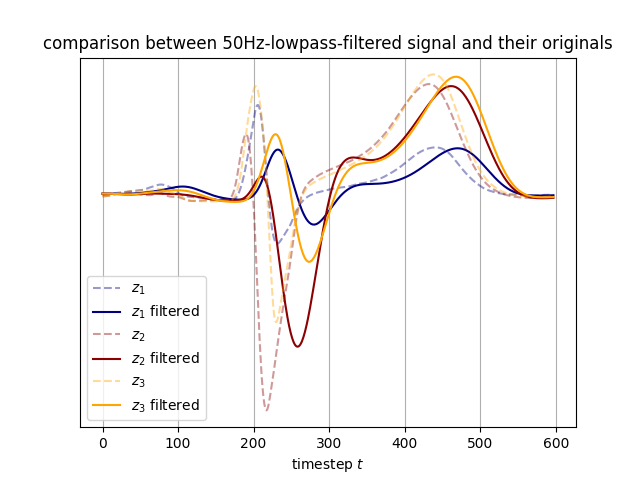

In [4652]:
%matplotlib notebook

plt.plot(z_1, c='navy', linestyle='--', alpha=.4, label='$z_1$')
plt.plot(z_1_filtered, c='navy', label='$z_1$ filtered')
plt.plot(z_2, c='darkred', linestyle='--', alpha=.4, label='$z_2$')
plt.plot(z_2_filtered, c='darkred', label='$z_2$ filtered')
plt.plot(z_3, c='orange', linestyle='--', alpha=.4, label='$z_3$')
plt.plot(z_3_filtered, c='orange', label='$z_3$ filtered')
plt.xlabel('timestep $t$')
plt.yticks([])
plt.legend()
plt.grid()
plt.title('comparison between 50Hz-lowpass-filtered signal and their originals')

plt.show()

In [4654]:
z_1 = z_1_filtered
z_2 = z_2_filtered
z_3 = z_3_filtered

In [4655]:
# since there is an offset between s[0] and s[-1] one needs to manipulate
# the series that is is truly periodical.
z_1_periodical = lambda t: z_1[t] - (z_1[-1] - z_1[0]) * t / len(z_1)
z_2_periodical = lambda t: z_2[t] - (z_2[-1] - z_2[0]) * t / len(z_2)
z_3_periodical = lambda t: z_3[t] - (z_3[-1] - z_3[0]) * t / len(z_3)

<IPython.core.display.Javascript object>


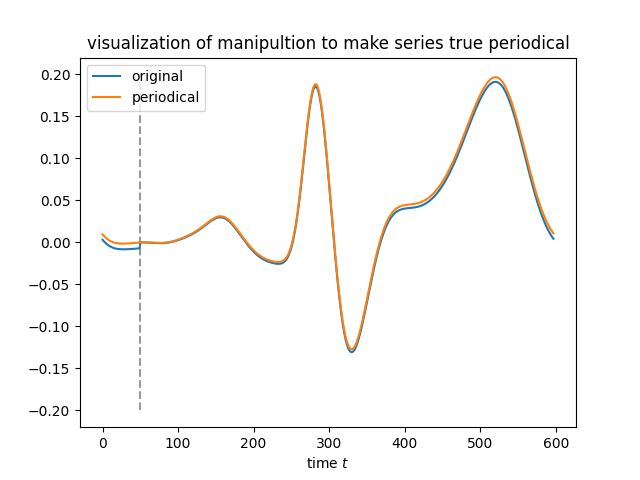

In [4656]:
%matplotlib notebook
plt.plot(np.roll(z_1, 50), label='original')
plt.plot(np.roll(z_1_periodical(np.arange(0, 598)), 50), label='periodical')
plt.vlines(50, -.2, .2, color='black', alpha=.4, linestyle='--')
plt.title('visualization of manipultion to make series true periodical')
plt.xlabel('time $t$')
plt.legend()
plt.show()

In [4657]:
z_1 = z_1_periodical(np.arange(0, len(z_1)))
z_2 = z_2_periodical(np.arange(0, len(z_2)))
z_3 = z_3_periodical(np.arange(0, len(z_3)))

In [4658]:
series = [z_1, z_2, z_3]

In [4659]:
# test if the series are truly periodical
print(z_1[0] - z_1[-1], z_2[0] - z_2[-1], z_3[0] - z_3[-1])

1.176854156746492e-05 2.9838505644456157e-05 2.4395196570809332e-05


<IPython.core.display.Javascript object>


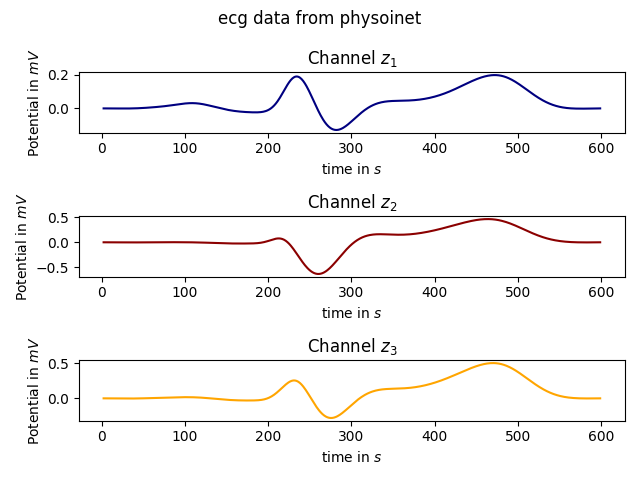

In [4660]:
%matplotlib notebook
plt.subplot(3, 1, 1)
plt.suptitle('ecg data from physoinet')
plt.title('Channel $z_1$')
plt.plot(data['time'], series[0], c='navy')
plt.xlabel('time in $s$')
plt.ylabel('Potential in $mV$')
plt.subplot(3, 1, 2)
plt.title('Channel $z_2$')
plt.plot(data['time'], series[1], c='darkred')
plt.xlabel('time in $s$')
plt.ylabel('Potential in $mV$')
plt.subplot(3, 1, 3)
plt.title('Channel $z_3$')
plt.plot(data['time'], series[2], c='orange')
plt.xlabel('time in $s$')
plt.ylabel('Potential in $mV$')
plt.tight_layout()
plt.show()

In [4661]:
#https://web.media.mit.edu/~crtaylor/calculator.html

def finite_difference_derivate_3_point(series):
    derivate = - np.roll(series, 1) + np.roll(series, -1)
    derivate = derivate / 2
    
    return derivate

def finite_difference_derivate_5_point(series):
    derivate = - np.roll(series, -2) + 8 * np.roll(series, -1) - 8 * np.roll(series, 1) + np.roll(series, 2)
    derivate = derivate / 12
    
    return derivate

def finite_difference_derivate_7_point(series):
    derivate = - np.roll(series, 3) + 9 * np.roll(series, 2) - 45 * np.roll(series, 1) + 45 * np.roll(series, -1) \
               - 9 * np.roll(series, -2) + np.roll(series, -3)
    derivate = derivate / 60
    
    return derivate

def finite_difference_derivate_9_point(series):
    derivate = - 3 * np.roll(series, 4) - 32 * np.roll(series, 3) + 168 * np.roll(series, 2) - 672 * np.roll(series, 1) \
               + 672 * np.roll(series, -1) - 168 * np.roll(series, -2) + 32 * np.roll(series, -3) - \
               3 * np.roll(series, -4)
    derivate = derivate / 840
    
    return derivate

In [4662]:
def second_order_upwind(series):
    '''    
    Returns the 1D second order upwind derivate of a one dimensional
    time series using reflecting boundary conditions.
    '''

    series = np.array(series)
    dx = 1
    d_pos = (- 3 * series \
             + 4 * np.roll(series, shift=-1, axis=0) \
             - np.roll(series, shift=-2, axis=0)
            ) / (2 * dx)
    d_neg = (+ 3 * series \
             - 4 * np.roll(series, shift=1, axis=0) \
             + np.roll(series, shift=2, axis=0)
            ) / (2 * dx)
    derivate = d_pos
    derivate[-3::] = d_neg[-3::]

    return derivate

def first_order_upwind(series):
    series = np.array(series)
    dx = 1
    
    d_pos = (series - np.roll(series, shift=1, axis=0)) / dx
    d_neg = (np.roll(series, shift=-1, axis=0) - series) / dx

    derivate = d_pos
    derivate[-2::] = d_neg[-2::]
    
    return derivate

def third_order_upwind(series):
    series = np.array(series)
    dx = 1
    
    d_pos = (- 2 * np.roll(series, shift=1) \
             - 3 * series \
             + 6 * np.roll(series, shift=-1) \
             - np.roll(series, shift=-2)
            ) / (6 * dx)
    d_neg = (+ 2 * np.roll(series, shift=-1) \
             + 3 * series \
             - 6 * np.roll(series, shift=1) \
             + np.roll(series, shift=2)
            ) / (6 * dx)
    
    derivate = d_pos
    derivate[-4::] = d_neg[-4::]

    return derivate

In [4663]:
def polynominal(dimension, grade):
    ''' returns the exponents of a polynominal
        of a given dimension to a given grade.
    '''
    # terminal condition
    if grade == 1:
        return np.identity(dimension)
        
    # get all possible combinations of grade x dimension
    tmp = product(range(grade + 1), repeat=dimension)
    tmp = list(tmp)
    
    # remove all which do not match grade
    tmp_ = []
    for i in range(len(tmp)):
        if np.sum(tmp[i]) == grade:
            tmp_.append(list(tmp[i]))
    
    # convert to full numpy array
    tmp_ = np.asarray([np.asarray(el) for el in tmp_])
    
    return np.append(polynominal(dimension, grade - 1), tmp_.T, axis=1)

In [4664]:
def fit_coefficients_3d_variable(y_1, y_2, y_3, z, grade, dimension=3):
    assert(dimension == 3)
    
    polynominal_exponents = polynominal(dimension, grade)
    
    len_polynominal = len(polynominal_exponents[0])
    
    a = np.ones((len_polynominal, len_polynominal))
    for i in range(len_polynominal):
        for j in range(len_polynominal):
            a[i][j] *= np.sum(y_1 ** (polynominal_exponents[0][j] + polynominal_exponents[0][i]) * \
                              y_2 ** (polynominal_exponents[1][j] + polynominal_exponents[1][i]) * \
                              y_3 ** (polynominal_exponents[2][j] + polynominal_exponents[2][i]))
    
    b = np.ones((len_polynominal, 1))
    for i in range(len_polynominal):
        b[i] *= np.sum(z * y_1 ** polynominal_exponents[0][i] * \
                           y_2 ** polynominal_exponents[1][i] * \
                           y_3 ** polynominal_exponents[2][i])
    
    return np.linalg.solve(a, b)

In [4665]:
def convert_fit_coefficients_to_function(p, grade, dimension=3):
    assert(dimension == 3)
    if type(p) != np.ndarray: return print('Wrong coefficient type:', type(p), 'Expected numpy.ndarray.')

    print('Polynominal of grade %i detected' % (grade))

    # TODO: n-dimensional function via array
    y_1_poly, y_2_poly, y_3_poly = polynominal(dimension, grade)

    def func(y_1, y_2, y_3):
        res = 0
        for i in range(len(p)):
            res += p[i] * y_1 ** y_1_poly[i] * y_2 ** y_2_poly[i] * y_3 ** y_3_poly[i]
        return res

    return func

<IPython.core.display.Javascript object>


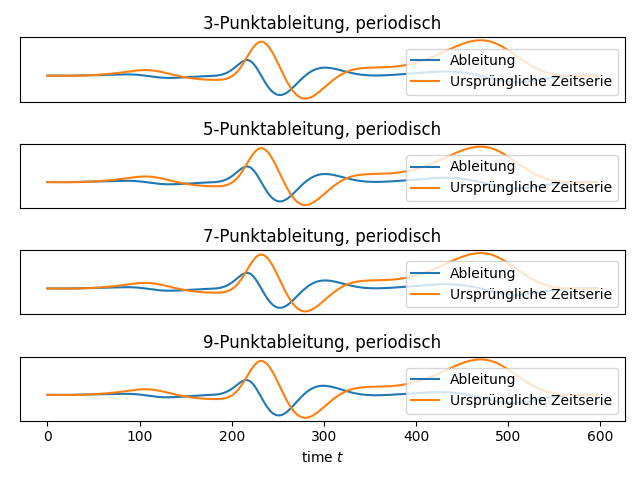

In [4666]:
%matplotlib notebook

plt.subplot(4, 1, 1)
plt.plot(finite_difference_derivate_3_point(z_1) * 10, label='Ableitung')
plt.plot(z_1, label='Ursprüngliche Zeitserie')
plt.yticks([])
plt.xticks([])
plt.legend()
plt.title('3-Punktableitung, periodisch')

plt.subplot(4, 1, 2)
plt.plot(finite_difference_derivate_5_point(z_1) * 10, label='Ableitung')
plt.plot(z_1, label='Ursprüngliche Zeitserie')
plt.yticks([])
plt.xticks([])
plt.legend()
plt.title('5-Punktableitung, periodisch')

plt.subplot(4, 1, 3)
plt.plot(finite_difference_derivate_7_point(z_1) * 10, label='Ableitung')
plt.plot(z_1, label='Ursprüngliche Zeitserie')
plt.yticks([])
plt.xticks([])
plt.legend()
plt.title('7-Punktableitung, periodisch')

plt.subplot(4, 1, 4)
plt.plot(finite_difference_derivate_9_point(z_1) * 10, label='Ableitung')
plt.plot(z_1, label='Ursprüngliche Zeitserie')
plt.yticks([])
plt.legend()
plt.title('9-Punktableitung, periodisch')

plt.xlabel('time $t$')
plt.tight_layout()
plt.show()

# fit to a 3d ode system
The time series $z_1, z_2, z_3$ will be fit to an system of connected ode's $\vec{y}$:

$$
y_1 = f_1(y_1, y_2, y_3; \vec{p})
\\
y_2 = f_2(y_1, y_2, y_3; \vec{q})
\\
y_3 = f_3(y_1, y_2, y_3; \vec{r})
$$

where the polynominal $f_i$ with it's grade $N_f=2$ is

$$
f_i(y_1, y_2, y_3) = p_0y_1+p_1y_2+p_2y_3 + p_3y_1^2+p_4y_1y_2+p_5y_1y_3+p_6y_2^2+p_7y_2y_3+p_8y_3^2
$$

In [4667]:
z_1_derivate = finite_difference_derivate_5_point(z_1)
z_2_derivate = finite_difference_derivate_5_point(z_2)
z_3_derivate = finite_difference_derivate_5_point(z_3)
z_1_min, z_1_max = min(z_1), max(z_1)
z_2_min, z_2_max = min(z_2), max(z_2)
z_3_min, z_3_max = min(z_3), max(z_3)

In [4668]:
grade = 4

p = fit_coefficients_3d_variable(z_1, z_2, z_3, z_1_derivate, grade)
q = fit_coefficients_3d_variable(z_1, z_2, z_3, z_2_derivate, grade)
r = fit_coefficients_3d_variable(z_1, z_2, z_3, z_3_derivate, grade)

In [4669]:
p_ = convert_fit_coefficients_to_function(p, grade)
q_ = convert_fit_coefficients_to_function(q, grade)
r_ = convert_fit_coefficients_to_function(r, grade)

Polynominal of grade 4 detected
Polynominal of grade 4 detected
Polynominal of grade 4 detected


In [4670]:
def func(t, x, fit_to_y_1, fit_to_y_2, fit_to_y_3):
    '''
    '''
    assert(abs(x[0]) <= 10000)
    
    y = [0, 0, 0]
    
    y[0] = fit_to_y_1(x[0], x[1], x[2])[0]
    y[1] = fit_to_y_2(x[0], x[1], x[2])[0]
    y[2] = fit_to_y_3(x[0], x[1], x[2])[0]
    return y

In [4706]:
T = len(z_1) // 2

ivp = [0, 0, 0]
index_start = 110

ivp[0] += z_1[index_start]
ivp[1] += z_2[index_start]
ivp[2] += z_3[index_start]

sol = solve_ivp(func, [0, T], ivp, dense_output=True, args=[p_, q_, r_], method='DOP853')

In [4707]:
f = 1
t = np.linspace(0, T, T*f)
y_1, y_2, y_3 = sol.sol(t)

res = (t, y_1, y_2, y_3)

<IPython.core.display.Javascript object>


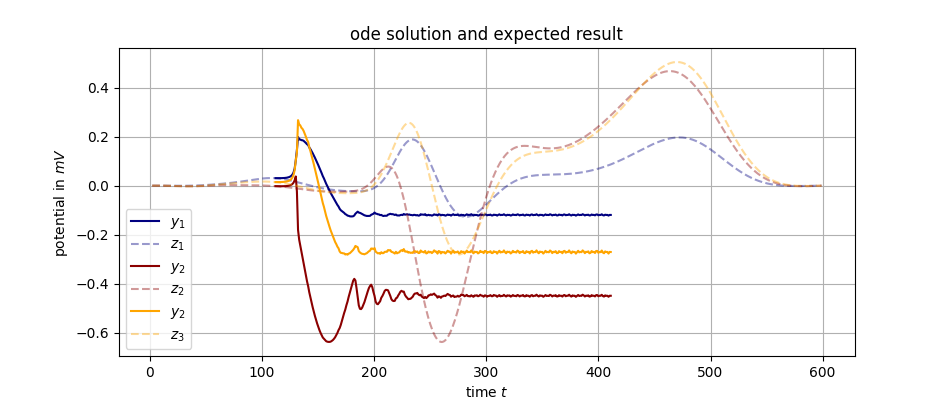

In [4708]:
%matplotlib notebook
mi = T

fig = plt.figure(figsize=(9.5, 4))

ax = fig.add_subplot(1, 1, 1)
ax.plot(res[0][:mi]+index_start+2, res[1][:mi], color='navy', label='$y_1$')
ax.plot(data['time'], z_1, linestyle='--', color='navy', alpha=.4, label='$z_1$')
ax.plot(res[0][:mi]+index_start+2, res[2][:mi], color='darkred', label='$y_2$')
ax.plot(data['time'], z_2, linestyle='--', color='darkred', alpha=.4, label='$z_2$')
ax.plot(res[0][:mi]+index_start+2, res[3][:mi], color='orange', label='$y_2$')
ax.plot(data['time'], z_3, linestyle='--', color='orange', alpha=.4, label='$z_3$')
ax.grid()
plt.legend()
plt.xlabel('time $t$')
plt.ylabel('potential in $mV$')
plt.title('ode solution and expected result')

fig.show()

<IPython.core.display.Javascript object>


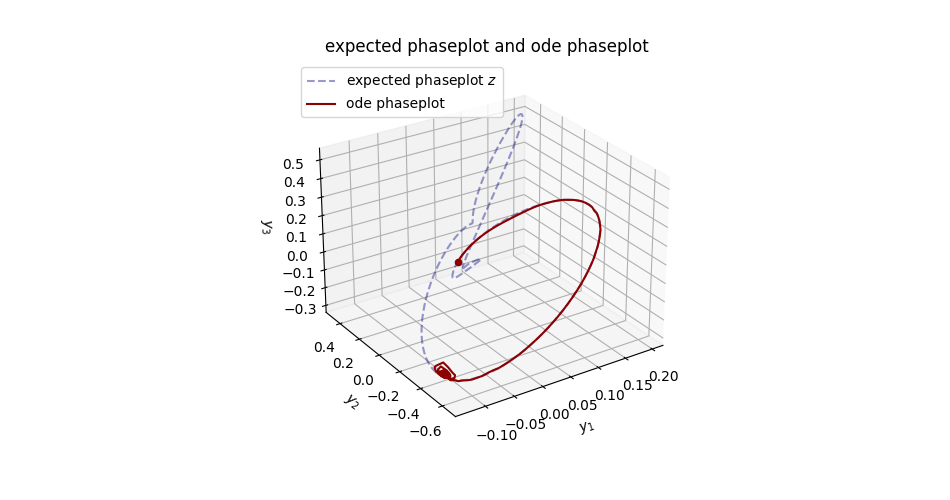

In [4674]:
%matplotlib notebook
fig = plt.figure(figsize=(9.5, 5))
ax = fig.gca(projection='3d')
plt.title('expected phaseplot and ode phaseplot')

ax.plot(z_1, z_2, z_3, c='navy', label='expected phaseplot $z$', alpha=.4, linestyle='--')
plt.plot(res[1][:mi], res[2][:mi], res[3][:mi], c='darkred', label='ode phaseplot')
ax.scatter(res[1][0], res[2][0], res[3][0], color='darkred')

ax.set_xlabel('$y_1$')
ax.set_ylabel('$y_2$')
ax.set_zlabel('$y_3$')

plt.legend()
plt.show()

# Searching for the most fitting ivp

In [1581]:
from pebble import concurrent

In [4675]:
# loop through all ivps from original time series
ivp_sweep_mse = [[], [], []]
for i in range(len(z_1)):
    print('iteration %i / %i' % (i, len(z_1)))
    
    ivp_= [0, 0, 0]
    ivp_[0] += z_1[i]
    ivp_[1] += z_2[i]
    ivp_[2] += z_3[i]
    
    T = len(z_1)
    
    @concurrent.process(timeout=60)
    def solve():
        return solve_ivp(func, [0, T], [ivp_[0], ivp_[1], ivp_[2]], dense_output=True, args=[p_, q_, r_])

    try:
        sol = solve().result()
    except Exception as e:
        print(e)
        print('[!] Error: appending mse=1000 instead. moving on')
        ivp_sweep_mse[0].append(1000)
        ivp_sweep_mse[1].append(1000)
        ivp_sweep_mse[2].append(1000)
        continue

    t = np.linspace(0, T, T)
    y_1, y_2, y_3 = sol.sol(t)

    ivp_sweep_mse[0].append(least_square_min(y_1, z_1))
    ivp_sweep_mse[1].append(least_square_min(y_2, z_2))
    ivp_sweep_mse[2].append(least_square_min(y_3, z_3))

iteration 0 / 598
iteration 1 / 598

[!] Error: appending mse=1000 instead. moving on
iteration 2 / 598
iteration 3 / 598
iteration 4 / 598
iteration 5 / 598
iteration 6 / 598
iteration 7 / 598
iteration 8 / 598

[!] Error: appending mse=1000 instead. moving on
iteration 9 / 598
iteration 10 / 598
iteration 11 / 598
iteration 12 / 598
iteration 13 / 598
iteration 14 / 598
iteration 15 / 598
iteration 16 / 598
iteration 17 / 598
iteration 18 / 598
iteration 19 / 598
iteration 20 / 598

[!] Error: appending mse=1000 instead. moving on
iteration 21 / 598

[!] Error: appending mse=1000 instead. moving on
iteration 22 / 598

[!] Error: appending mse=1000 instead. moving on
iteration 23 / 598

[!] Error: appending mse=1000 instead. moving on
iteration 24 / 598
iteration 25 / 598
iteration 26 / 598
iteration 27 / 598
iteration 28 / 598
iteration 29 / 598
iteration 30 / 598
iteration 31 / 598
iteration 32 / 598
iteration 33 / 598
iteration 34 / 598

[!] Error: appending mse=1000 instead. movin


[!] Error: appending mse=1000 instead. moving on
iteration 288 / 598
iteration 289 / 598
iteration 290 / 598
iteration 291 / 598

[!] Error: appending mse=1000 instead. moving on
iteration 292 / 598

[!] Error: appending mse=1000 instead. moving on
iteration 293 / 598

[!] Error: appending mse=1000 instead. moving on
iteration 294 / 598

[!] Error: appending mse=1000 instead. moving on
iteration 295 / 598

[!] Error: appending mse=1000 instead. moving on
iteration 296 / 598

[!] Error: appending mse=1000 instead. moving on
iteration 297 / 598

[!] Error: appending mse=1000 instead. moving on
iteration 298 / 598

[!] Error: appending mse=1000 instead. moving on
iteration 299 / 598

[!] Error: appending mse=1000 instead. moving on
iteration 300 / 598

[!] Error: appending mse=1000 instead. moving on
iteration 301 / 598

[!] Error: appending mse=1000 instead. moving on
iteration 302 / 598
iteration 303 / 598
iteration 304 / 598
iteration 305 / 598
iteration 306 / 598
iteration 307 / 598


iteration 565 / 598
iteration 566 / 598
iteration 567 / 598
iteration 568 / 598
iteration 569 / 598
iteration 570 / 598
iteration 571 / 598
iteration 572 / 598
iteration 573 / 598
iteration 574 / 598
iteration 575 / 598
iteration 576 / 598
iteration 577 / 598
iteration 578 / 598
iteration 579 / 598
iteration 580 / 598
iteration 581 / 598
iteration 582 / 598
iteration 583 / 598
iteration 584 / 598
iteration 585 / 598
iteration 586 / 598
iteration 587 / 598
iteration 588 / 598

[!] Error: appending mse=1000 instead. moving on
iteration 589 / 598

[!] Error: appending mse=1000 instead. moving on
iteration 590 / 598

[!] Error: appending mse=1000 instead. moving on
iteration 591 / 598

[!] Error: appending mse=1000 instead. moving on
iteration 592 / 598

[!] Error: appending mse=1000 instead. moving on
iteration 593 / 598
iteration 594 / 598
iteration 595 / 598
iteration 596 / 598
iteration 597 / 598


In [4676]:
ivp_sweep_mse_ = np.asarray(ivp_sweep_mse)

ivp_sweep_mse_[0][ivp_sweep_mse_[0] > 999] = np.nan
ivp_sweep_mse_[1][ivp_sweep_mse_[1] > 999] = np.nan
ivp_sweep_mse_[2][ivp_sweep_mse_[2] > 999] = np.nan

<IPython.core.display.Javascript object>


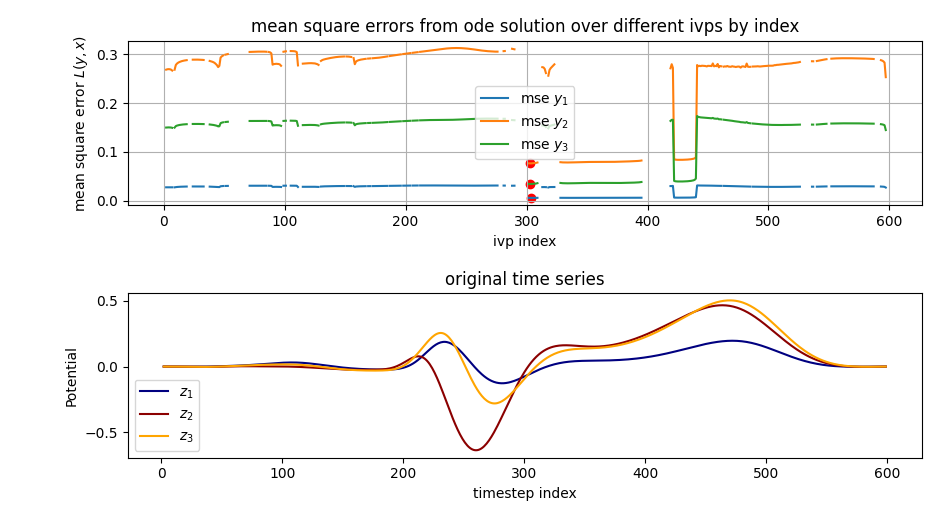

In [4678]:
%matplotlib notebook
plt.subplot(2, 1, 1)
plt.title('mean square errors from ode solution over different ivps by index')
plt.plot(ivp_sweep_mse_[0], label='mse $y_1$')
plt.scatter(np.where(ivp_sweep_mse[0] == min(ivp_sweep_mse[0])), min(ivp_sweep_mse[0]), c='r')
plt.plot(ivp_sweep_mse_[1], label='mse $y_2$')
plt.scatter(np.where(ivp_sweep_mse[1] == min(ivp_sweep_mse[1])), min(ivp_sweep_mse[1]), c='r')
plt.plot(ivp_sweep_mse_[2], label='mse $y_3$')
plt.scatter(np.where(ivp_sweep_mse[2] == min(ivp_sweep_mse[2])), min(ivp_sweep_mse[2]), c='r')
plt.xlabel('ivp index')
plt.ylabel('mean square error $L(y,x)$')
#plt.ylim(0, .1)
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.title('original time series')
#plt.bar(205, .7, 37, alpha=.3, color='orange')
plt.plot(data['time'], 1*z_1, linestyle='-', color='navy', label='$z_1$')
plt.plot(data['time'], 1*z_2, linestyle='-', color='darkred', label='$z_2$')
plt.plot(data['time'], 1*z_3, linestyle='-', color='orange', label='$z_3$')
plt.legend()
plt.xlabel('timestep index')
plt.ylabel('Potential')
plt.tight_layout()
plt.show()

In [4679]:
print(np.where(ivp_sweep_mse[0] == min(ivp_sweep_mse[0])))
print(np.where(ivp_sweep_mse[1] == min(ivp_sweep_mse[1])))
print(np.where(ivp_sweep_mse[2] == min(ivp_sweep_mse[2])))

(array([304]),)
(array([303]),)
(array([303]),)


In [2929]:
# search for optimum ivp in region close of singualar ivp
ivp = [0, 0, 0]

ivp[0] += z_1[15]
ivp[1] += z_2[14]
ivp[2] += z_3[14]

epsilon = .02
evaluating_ivp = [[],[], []]
for i in np.linspace(-1, 1, 10):
    for j in np.linspace(-1, 1, 10):
        for k in np.linspace(-1, 1, 10): # complexity n^3! -> which means when 50->14 days calculation, 10->1.38h calc
            evaluating_ivp[0].append(ivp[0] + epsilon * i)
            evaluating_ivp[1].append(ivp[1] + epsilon * j)
            evaluating_ivp[2].append(ivp[2] + epsilon * k)

<IPython.core.display.Javascript object>


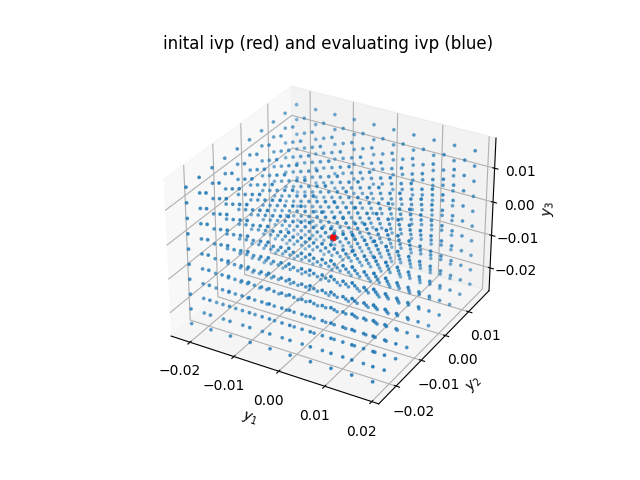

In [2930]:
%matplotlib notebook
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(evaluating_ivp[0], evaluating_ivp[1], evaluating_ivp[2], s=3)
ax.scatter(ivp[0], ivp[1], ivp[2], c='r')
ax.set_title('inital ivp (red) and evaluating ivp (blue)')
ax.set_xlabel('$y_1$')
ax.set_ylabel('$y_2$')
ax.set_zlabel('$y_3$')
plt.show()

In [2931]:
def least_square_min(y, x):
    return np.mean((y - x) ** 2)

In [2932]:
lse_ = [[], [], []]

T = len(z_1)

for i in range(len(evaluating_ivp[0])):
    print('iteration %i / %i' % (i, len(evaluating_ivp[0])))
    try:
        sol = solve_ivp(func, [0, T], [evaluating_ivp[0][i], evaluating_ivp[1][i], evaluating_ivp[2][i]], \
                        dense_output=True, args=[p_, q_, r_])
    except Exception as e:
        print(e, 'appending mse=1000 instead. moving on.')
        lse_[0].append(1000)
        lse_[1].append(1000)
        lse_[2].append(1000)
        continue
        
    t = np.linspace(0, T, T)
    y_1, y_2, y_3 = sol.sol(t)

    lse_[0].append(least_square_min(y_1, z_1))
    lse_[1].append(least_square_min(y_2, z_2))
    lse_[2].append(least_square_min(y_3, z_3))

iteration 0 / 1000
 appending mse=1000 instead. moving on.
iteration 1 / 1000
 appending mse=1000 instead. moving on.
iteration 2 / 1000
 appending mse=1000 instead. moving on.
iteration 3 / 1000
 appending mse=1000 instead. moving on.
iteration 4 / 1000
 appending mse=1000 instead. moving on.
iteration 5 / 1000
 appending mse=1000 instead. moving on.
iteration 6 / 1000
 appending mse=1000 instead. moving on.
iteration 7 / 1000
 appending mse=1000 instead. moving on.
iteration 8 / 1000
 appending mse=1000 instead. moving on.
iteration 9 / 1000
 appending mse=1000 instead. moving on.
iteration 10 / 1000
 appending mse=1000 instead. moving on.
iteration 11 / 1000
 appending mse=1000 instead. moving on.
iteration 12 / 1000
 appending mse=1000 instead. moving on.
iteration 13 / 1000
 appending mse=1000 instead. moving on.
iteration 14 / 1000
 appending mse=1000 instead. moving on.
iteration 15 / 1000
 appending mse=1000 instead. moving on.
iteration 16 / 1000
 appending mse=1000 instead. m

 appending mse=1000 instead. moving on.
iteration 140 / 1000
 appending mse=1000 instead. moving on.
iteration 141 / 1000
 appending mse=1000 instead. moving on.
iteration 142 / 1000
 appending mse=1000 instead. moving on.
iteration 143 / 1000
 appending mse=1000 instead. moving on.
iteration 144 / 1000
 appending mse=1000 instead. moving on.
iteration 145 / 1000
 appending mse=1000 instead. moving on.
iteration 146 / 1000
 appending mse=1000 instead. moving on.
iteration 147 / 1000
 appending mse=1000 instead. moving on.
iteration 148 / 1000
 appending mse=1000 instead. moving on.
iteration 149 / 1000
 appending mse=1000 instead. moving on.
iteration 150 / 1000
 appending mse=1000 instead. moving on.
iteration 151 / 1000
 appending mse=1000 instead. moving on.
iteration 152 / 1000
 appending mse=1000 instead. moving on.
iteration 153 / 1000
 appending mse=1000 instead. moving on.
iteration 154 / 1000
 appending mse=1000 instead. moving on.
iteration 155 / 1000
 appending mse=1000 inst

 appending mse=1000 instead. moving on.
iteration 278 / 1000
 appending mse=1000 instead. moving on.
iteration 279 / 1000
 appending mse=1000 instead. moving on.
iteration 280 / 1000
 appending mse=1000 instead. moving on.
iteration 281 / 1000
 appending mse=1000 instead. moving on.
iteration 282 / 1000
iteration 283 / 1000
 appending mse=1000 instead. moving on.
iteration 284 / 1000
 appending mse=1000 instead. moving on.
iteration 285 / 1000
 appending mse=1000 instead. moving on.
iteration 286 / 1000
 appending mse=1000 instead. moving on.
iteration 287 / 1000
 appending mse=1000 instead. moving on.
iteration 288 / 1000
 appending mse=1000 instead. moving on.
iteration 289 / 1000
 appending mse=1000 instead. moving on.
iteration 290 / 1000
 appending mse=1000 instead. moving on.
iteration 291 / 1000
 appending mse=1000 instead. moving on.
iteration 292 / 1000
 appending mse=1000 instead. moving on.
iteration 293 / 1000
 appending mse=1000 instead. moving on.
iteration 294 / 1000
 ap

 appending mse=1000 instead. moving on.
iteration 420 / 1000
 appending mse=1000 instead. moving on.
iteration 421 / 1000
iteration 422 / 1000
iteration 423 / 1000
 appending mse=1000 instead. moving on.
iteration 424 / 1000
 appending mse=1000 instead. moving on.
iteration 425 / 1000
 appending mse=1000 instead. moving on.
iteration 426 / 1000
 appending mse=1000 instead. moving on.
iteration 427 / 1000
 appending mse=1000 instead. moving on.
iteration 428 / 1000
 appending mse=1000 instead. moving on.
iteration 429 / 1000
 appending mse=1000 instead. moving on.
iteration 430 / 1000
 appending mse=1000 instead. moving on.
iteration 431 / 1000
 appending mse=1000 instead. moving on.
iteration 432 / 1000
 appending mse=1000 instead. moving on.
iteration 433 / 1000
 appending mse=1000 instead. moving on.
iteration 434 / 1000
 appending mse=1000 instead. moving on.
iteration 435 / 1000
 appending mse=1000 instead. moving on.
iteration 436 / 1000
 appending mse=1000 instead. moving on.
ite

 appending mse=1000 instead. moving on.
iteration 564 / 1000
 appending mse=1000 instead. moving on.
iteration 565 / 1000
iteration 566 / 1000
iteration 567 / 1000
 appending mse=1000 instead. moving on.
iteration 568 / 1000
 appending mse=1000 instead. moving on.
iteration 569 / 1000
 appending mse=1000 instead. moving on.
iteration 570 / 1000
 appending mse=1000 instead. moving on.
iteration 571 / 1000
 appending mse=1000 instead. moving on.
iteration 572 / 1000
 appending mse=1000 instead. moving on.
iteration 573 / 1000
 appending mse=1000 instead. moving on.
iteration 574 / 1000
 appending mse=1000 instead. moving on.
iteration 575 / 1000
 appending mse=1000 instead. moving on.
iteration 576 / 1000
iteration 577 / 1000
 appending mse=1000 instead. moving on.
iteration 578 / 1000
 appending mse=1000 instead. moving on.
iteration 579 / 1000
 appending mse=1000 instead. moving on.
iteration 580 / 1000
 appending mse=1000 instead. moving on.
iteration 581 / 1000
 appending mse=1000 in

 appending mse=1000 instead. moving on.
iteration 712 / 1000
 appending mse=1000 instead. moving on.
iteration 713 / 1000
 appending mse=1000 instead. moving on.
iteration 714 / 1000
 appending mse=1000 instead. moving on.
iteration 715 / 1000
iteration 716 / 1000
 appending mse=1000 instead. moving on.
iteration 717 / 1000
iteration 718 / 1000
 appending mse=1000 instead. moving on.
iteration 719 / 1000
 appending mse=1000 instead. moving on.
iteration 720 / 1000
 appending mse=1000 instead. moving on.
iteration 721 / 1000
 appending mse=1000 instead. moving on.
iteration 722 / 1000
 appending mse=1000 instead. moving on.
iteration 723 / 1000
 appending mse=1000 instead. moving on.
iteration 724 / 1000
 appending mse=1000 instead. moving on.
iteration 725 / 1000
iteration 726 / 1000
 appending mse=1000 instead. moving on.
iteration 727 / 1000
 appending mse=1000 instead. moving on.
iteration 728 / 1000
 appending mse=1000 instead. moving on.
iteration 729 / 1000
 appending mse=1000 in

 appending mse=1000 instead. moving on.
iteration 857 / 1000
 appending mse=1000 instead. moving on.
iteration 858 / 1000
 appending mse=1000 instead. moving on.
iteration 859 / 1000
iteration 860 / 1000
 appending mse=1000 instead. moving on.
iteration 861 / 1000
 appending mse=1000 instead. moving on.
iteration 862 / 1000
 appending mse=1000 instead. moving on.
iteration 863 / 1000
 appending mse=1000 instead. moving on.
iteration 864 / 1000
 appending mse=1000 instead. moving on.
iteration 865 / 1000
 appending mse=1000 instead. moving on.
iteration 866 / 1000
 appending mse=1000 instead. moving on.
iteration 867 / 1000
 appending mse=1000 instead. moving on.
iteration 868 / 1000
 appending mse=1000 instead. moving on.
iteration 869 / 1000
 appending mse=1000 instead. moving on.
iteration 870 / 1000
 appending mse=1000 instead. moving on.
iteration 871 / 1000
 appending mse=1000 instead. moving on.
iteration 872 / 1000
 appending mse=1000 instead. moving on.
iteration 873 / 1000
 ap

 appending mse=1000 instead. moving on.
iteration 994 / 1000
 appending mse=1000 instead. moving on.
iteration 995 / 1000
 appending mse=1000 instead. moving on.
iteration 996 / 1000
 appending mse=1000 instead. moving on.
iteration 997 / 1000
 appending mse=1000 instead. moving on.
iteration 998 / 1000
 appending mse=1000 instead. moving on.
iteration 999 / 1000
 appending mse=1000 instead. moving on.


In [2933]:
lse = np.asarray([np.asarray([np.asarray(el) for el in sel]) for sel in lse_])

In [2934]:
lse[0][lse[0] > 999] = np.nan
lse[1][lse[1] > 999] = np.nan
lse[2][lse[2] > 999] = np.nan

In [2935]:
print(min(lse_[0]), min(lse_[1]), min(lse_[2]))
print(lse_[0].index(min(lse_[0])), lse_[1].index(min(lse_[1])), lse_[2].index(min(lse_[2])))
k_1 = lse_[0].index(min(lse_[0]))
k_2 = lse_[1].index(min(lse_[1]))
k_3 = lse_[2].index(min(lse_[2]))

0.0009581145174258549 0.0115465586118778 0.0077274131950726905
412 412 412


<IPython.core.display.Javascript object>


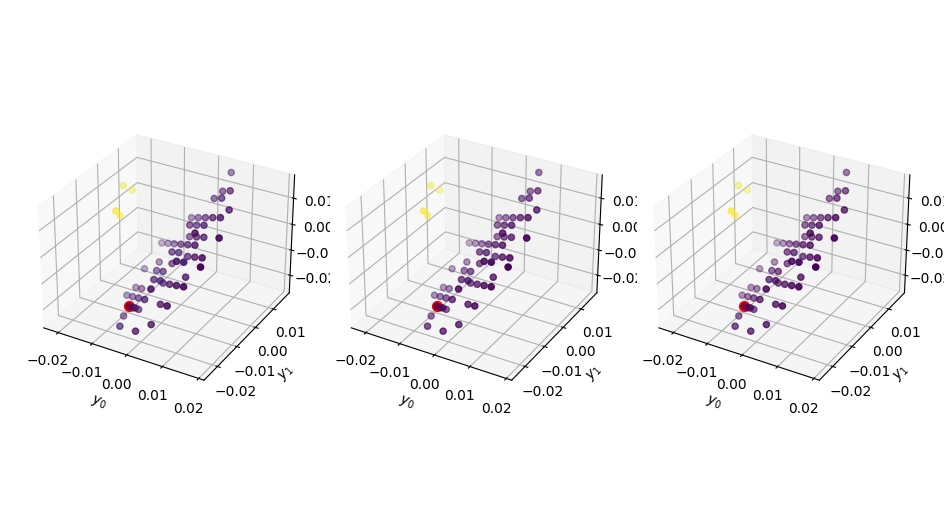

In [2942]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.scatter(evaluating_ivp[0], evaluating_ivp[1], evaluating_ivp[2], c=lse[0])
ax.scatter(evaluating_ivp[0][k_1], evaluating_ivp[1][k_1], evaluating_ivp[2][k_1], c='r', s=50)
ax.set_xlabel('$y_0$')
ax.set_ylabel('$y_1$')
ax.set_zlabel('$y_2$')

ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.scatter(evaluating_ivp[0], evaluating_ivp[1], evaluating_ivp[2], c=lse[1])
ax.scatter(evaluating_ivp[0][k_2], evaluating_ivp[1][k_2], evaluating_ivp[2][k_2], c='r', s=50)
ax.set_xlabel('$y_0$')
ax.set_ylabel('$y_1$')
ax.set_zlabel('$y_2$')

ax = fig.add_subplot(1, 3, 3, projection='3d')
c = ax.scatter(evaluating_ivp[0], evaluating_ivp[1], evaluating_ivp[2], c=lse[2])
ax.scatter(evaluating_ivp[0][k_3], evaluating_ivp[1][k_3], evaluating_ivp[2][k_3], c='r', s=50)
ax.set_xlabel('$y_0$')
ax.set_ylabel('$y_1$')
ax.set_zlabel('$y_2$')
#fig.colorbar(c)

plt.tight_layout()
plt.show()

In [2948]:
T = len(z_1)

ivp = [0, 0, 0]
ivp[0] += evaluating_ivp[0][k_1]
ivp[1] += evaluating_ivp[1][k_2]
ivp[2] += evaluating_ivp[2][k_3]

sol = solve_ivp(func, [0, T], ivp, dense_output=True, args=[p_, q_, r_], method='DOP853')

In [2949]:
f = 1
t = np.linspace(0, T, T*f)
y_1, y_2, y_3 = sol.sol(t)

res = (t, y_1, y_2, y_3)

<IPython.core.display.Javascript object>


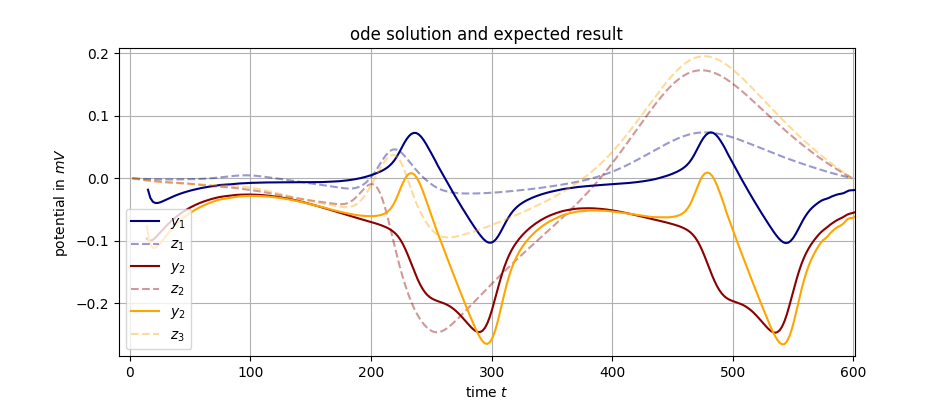

In [2954]:
%matplotlib notebook
mi = T

fig = plt.figure(figsize=(9.5, 4))

ax = fig.add_subplot(1, 1, 1)
ax.plot(2*res[0][:mi]+15, 5*res[1][:mi], color='navy', label='$y_1$')
ax.plot(data['time'], z_1, linestyle='--', color='navy', alpha=.4, label='$z_1$')
ax.plot(2*res[0][:mi]+14, 5*res[2][:mi], color='darkred', label='$y_2$')
ax.plot(data['time'], z_2, linestyle='--', color='darkred', alpha=.4, label='$z_2$')
ax.plot(2*res[0][:mi]+14, 5*res[3][:mi], color='orange', label='$y_2$')
ax.plot(data['time'], z_3, linestyle='--', color='orange', alpha=.4, label='$z_3$')
ax.grid()
plt.legend()
plt.xlabel('time $t$')
plt.ylabel('potential in $mV$')
plt.title('ode solution and expected result')

fig.show()

<IPython.core.display.Javascript object>


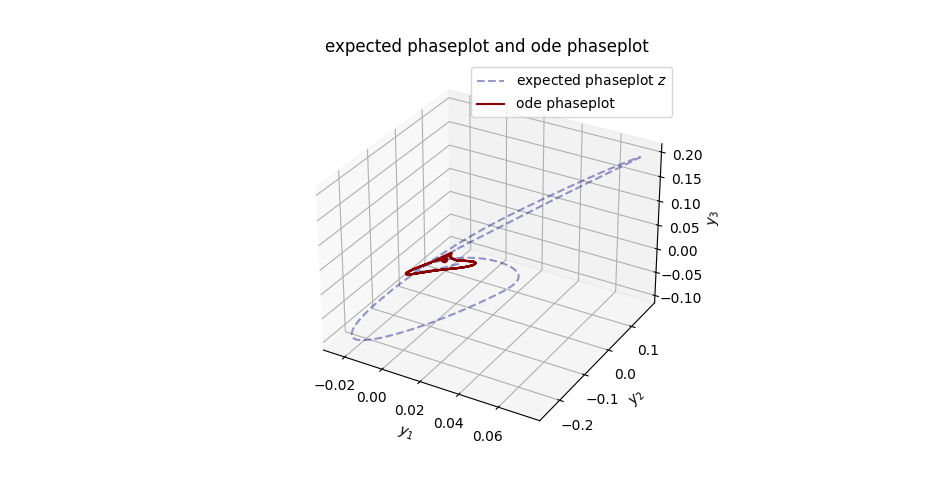

In [2940]:
%matplotlib notebook
fig = plt.figure(figsize=(9.5, 5))
ax = fig.gca(projection='3d')
plt.title('expected phaseplot and ode phaseplot')

ax.plot(z_1, z_2, z_3, c='navy', label='expected phaseplot $z$', alpha=.4, linestyle='--')
plt.plot(res[1][:mi], res[2][:mi], res[3][:mi], c='darkred', label='ode phaseplot')
ax.scatter(res[1][0], res[2][0], res[3][0], color='darkred')

ax.set_xlabel('$y_1$')
ax.set_ylabel('$y_2$')
ax.set_zlabel('$y_3$')

plt.legend()
plt.show()

# Graveyard
old static functions

In [952]:
def fit_coefficients_3d(y_1, y_2, y_3, z, _):
    print('function "convert_coeffictents_to_fit_function" is deprecated and will be removed soon')
    return 0
    
    pr = y_1 * y_2 * y_3 # product of all three, since this saves time
    
    a = [
         [np.sum(y_1 ** 2), np.sum(y_1 * y_2), np.sum(y_1 * y_3), np.sum(y_1 ** 3), np.sum(y_1 ** 2 * y_2), \
          np.sum(y_1 ** 2 * y_3), np.sum(y_1 * y_2 ** 2), np.sum(pr), np.sum(y_1 * y_3 ** 2)],
         [np.sum(y_1 * y_2), np.sum(y_2 ** 2), np.sum(y_2 * y_3), np.sum(y_1 ** 2 * y_2), np.sum(y_1 * y_2 ** 2), \
          np.sum(pr), np.sum(y_2 ** 3), np.sum(y_2 ** 2 * y_3), np.sum(y_2 * y_3 ** 2)],
         [np.sum(y_1 * y_3), np.sum(y_2 * y_3), np.sum(y_3 ** 2), np.sum(y_1 ** 2 * y_3), np.sum(pr), \
          np.sum(y_1 * y_3 ** 2), np.sum(y_2 ** 2 * y_3), np.sum(y_2 * y_3 ** 2), np.sum(y_3 ** 3)],
         [np.sum(y_1 ** 4), np.sum(y_1 ** 2 * y_2), np.sum(y_1 ** 2 * y_3), np.sum(y_1 ** 4), np.sum(y_1 ** 3 * y_2), \
          np.sum(y_1 ** 3 * y_3), np.sum(y_1 ** 2 * y_2 ** 2), np.sum(pr * y_1), np.sum(y_1 ** 2 * y_3 ** 2)],
         [np.sum(y_1 ** 2 * y_2), np.sum(y_1 * y_2 ** 2), np.sum(pr), np.sum(y_1 ** 3 * y_2), np.sum(y_1 ** 2 * y_2 ** 2), \
          np.sum(pr * y_1), np.sum(y_1 * y_2 ** 3), np.sum(pr * y_2), np.sum(pr * y_3)],
         [np.sum(y_1 ** 2 * y_3), np.sum(pr), np.sum(y_1 * y_3 ** 2), np.sum(y_1 ** 3 * y_3), np.sum(pr * y_1), \
          np.sum(y_1 ** 2 * y_3 ** 2), np.sum(pr * y_2), np.sum(pr * y_3), np.sum(y_1 * y_3 ** 3)],
         [np.sum(y_1 * y_2 ** 2), np.sum(y_2 ** 3), np.sum(y_2 ** 2 * y_3), np.sum(y_1 ** 2 * y_2 ** 2), \
          np.sum(y_1 * y_2 ** 3), np.sum(pr * y_2), np.sum(y_2 ** 4), np.sum(y_2 ** 3 * y_3), np.sum(y_2 ** 2 * y_3 ** 2)],
         [np.sum(pr), np.sum(y_2 ** 2 * y_3), np.sum(y_2 * y_3 ** 2), np.sum(pr * y_1), np.sum(pr * y_2), \
          np.sum(pr * y_3), np.sum(y_2 ** 3 * y_3), np.sum(y_2 ** 2 * y_3 ** 2), np.sum(y_2 * y_3 ** 3)],
         [np.sum(y_1 * y_3 ** 2), np.sum(y_2 * y_3 ** 2), np.sum(y_3 ** 3), np.sum(y_1 ** 2 * y_3 ** 2), \
          np.sum(pr * y_3), np.sum(y_1 * y_3 ** 3), np.sum(y_2 ** 2 * y_3 ** 2), np.sum(y_2 * y_3 ** 3), np.sum(y_3 ** 4)],
        ]
    b = [
         [np.sum(z * y_1)],
         [np.sum(z * y_2)],
         [np.sum(z * y_3)],
         [np.sum(z * y_1 ** 2)],
         [np.sum(z * y_1 * y_2)],
         [np.sum(z * y_1 * y_3)],
         [np.sum(z * y_2 ** 2)],
         [np.sum(z * y_2 * y_3)],
         [np.sum(z * y_3 ** 2)],
        ]
    
    #print(np.asarray(a))
    #print(np.asarray(b))
    
    return np.linalg.solve(a, b)

In [954]:
def convert_coeffictents_to_fit_function_static(p):
    assert(len(p) == 9)
    print('function "convert_coeffictents_to_fit_function" is deprecated and will be removed soon')
    return 0

    def func(y_1, y_2, y_3):
        res = p[0] * y_1 + p[1] * y_2 + p[2] * y_3 + p[3] * y_1 ** 2 + p[4] * y_1 * y_2 + p[5] * y_1 * y_3 + \
              p[6] * y_2 ** 2 + p[7] * y_2 * y_3 + p[8] * y_3 ** 2
        return res
    return func

In [955]:
def polynominal_3d(grade):
    assert(0 < grade <= 4)
    return 0
    
    p = [
            [1, 0, 0, 2, 1, 1, 0, 0, 0, 3, 2, 2, 1, 1, 1, 0, 0, 0, 0, 4, 3, 3, 2, 2, 2, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0],
            [0, 1, 0, 0, 1, 0, 2, 1, 0, 0, 1, 0, 2, 0, 1, 3, 2, 1, 0, 0, 1, 0, 2, 0, 1, 3, 0, 4, 3, 2, 2, 1, 0, 1, 3],
            [0, 0, 1, 0, 0, 1, 0, 1, 2, 0, 0, 1, 0, 2, 1, 0, 1, 2, 3, 0, 0, 1, 0, 2, 1, 0, 3, 0, 1, 2, 1, 3, 4, 2, 1],
        ] # |linear|  |--quadratic---|  |----------cubic-----------|  |-----------------grade 4--------------------|
    p = np.asarray(p)
    
    if grade == 1:
        return p[::, :3]
    if grade == 2:
        return p[::, :9]
    if grade == 3:
        return p[::, :19]
    if grade == 4:
        return p